In [23]:
import os
import pandas as pd
import altair as alt
# Set Path
path_wd = '/content/drive/MyDrive/Github/Content'
os.chdir(path_wd)

In [ ]:
!pip install -r requirements.txt
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

In [12]:
!#Load Libraries
import gc
import pandas as pd
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

# Initialize Registration Class
driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: use options instead of chrome_options
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
# For obtaining data from the net
from bs4 import BeautifulSoup
import re

url = 'https://m.hx168.com.cn/stock/concept/BK2505.html'
driver.get(url)
driver.implicitly_wait(2)
html = driver.page_source

tables = pd.read_html(html)

In [ ]:
from sources.ChinaFilm.Record_Registration import Estimate_Registration
reg_est = Estimate_Registration()
df_wona = df.dropna()
df_wona_est = reg_est.complete_dt(df_wona)

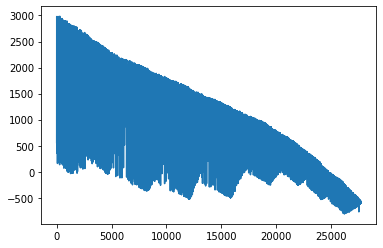

In [48]:
df_wona_est['备案通过日偏差'].plot()

In [31]:
from sources.ChinaFilm.Record_Registration import Registration
dy_reg = Registration(driver)
gc.collect()
#os.chdir('sources/ChinaFilm')
#df = dy_reg.Refined_Records(update_first=False)
df.columns

Index(['备案立项号', '片名', '备案单位', '编剧', '备案结果', '备案地', '梗概', '公示日期', '公示批次名称',
       '备案详细页链接', '公示批次链接', '公示年', '公示批次起始', '类型', '备案申请年份', '备案立项年度顺序号',
       '公示覆盖期间', '公示覆盖天数'],
      dtype='object')

In [40]:
curr_issue_name = df.sort_values(['公示日期', '公示批次名称'], ascending=False)['公示批次名称'].iloc[0]
df_curr =  df.loc[df.公示批次名称 == curr_issue_name,]
df_curr.iloc[0]

备案立项号                                         影剧备字[2019]第9631号
片名                                                        天路彩虹
备案单位                                                中国交通报社有限公司
编剧                                                          冯斌
备案结果                                               同意拍摄  (补)  
备案地                                                 北京市  (补)  
梗概           交通扶贫工作是全国脱贫的重要组成部分。做好交通扶贫工作，是推进经济欠发达地区交通运输跨越式发...
公示日期                                       2020-11-03 11:45:00
公示批次名称                     国家电影局关于2020年05月全国电影剧本（梗概）备案、立项公示的通知
备案详细页链接      http://dy.chinasarft.gov.cn/shanty.deploy/blue...
公示批次链接       http://dy.chinasarft.gov.cn/shanty.deploy/blue...
公示年                                                       2020
公示批次起始                                  (2020, 05, 整月, 05, 整月)
类型                                                         故事片
备案申请年份                                                    2019
备案立项年度顺序号                                              

In [50]:
df_curr.loc[0,'公示批次起始'][0]

('2020', '05', '整月', '05', '整月')

XXXX年XX月XX日，最新的备案公示新鲜出炉！
这一批次中，最遥远的项目是XXX, 最近期的项目是XXX，预计处理的大部分备案是在XXX至XXX期间完成提交。


In [54]:
record_earliest = df_curr.sort_values(['备案申请年份', '备案立项年度顺序号'])[:1]
record_latest = df_curr.sort_values(['备案申请年份', '备案立项年度顺序号'])[-1:]
df_curr['公示日期'] = df_curr['公示日期'].astype('datetime64')

txt = ''
txt += str(df_curr[:1]['公示日期'].dt.date.iloc[0].year) + '年' + str(df_curr[:1]['公示日期'].dt.date.iloc[0].month) + '月' \
 + str(df_curr[:1]['公示日期'].dt.date.iloc[0].day) + '日，'
txt += ''
txt += df_curr.loc[0,'公示批次起始'][0] + '年' + df_curr.loc[0,'公示批次起始'][1] + '月'
txt += df_curr.loc[0,'公示批次起始'][2]
txt += '处理完毕的备案公示新鲜出炉！ 这一批次中，最遥远的项目是'
txt += '《' + record_earliest['片名'].iloc[0] + '》,'
txt += '备案号为' + record_earliest['备案立项号'].iloc[0] + ','
txt += '最近期的项目是' + '《' + record_latest['片名'].iloc[0] + '》,'
txt += '备案号为' + record_latest['备案立项号'].iloc[0] + '。'

print(txt)

2020年11月3日，2020年05月整月处理完毕的备案公示新鲜出炉！ 这一批次中，最遥远的项目是《终极心跳》,备案号为影剧备字[2017]第3452号,最近期的项目是《扣杀》,备案号为影剧备字[2020]第7310号。


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
record_earliest['备案立项号'].iloc[0]

'影剧备字[2017]第3452号'

备案中，国家电影局直备的有XX部，各地备案量排名前三的分别是XXX、XXX、XXX。
补备案的共有两部，先拍片、再备案属于高风险行为，切记慎之又慎。

In [109]:
df_curr.groupby('备案地')['备案地'].count().sort_values(ascending=False).index


Index(['北京市', '上海市', '广东省', '山东省', '福建省', '直备', '陕西省', '甘肃省', '四川省', '河南省',
       '山西省', '浙江省', '江苏省', '天津市', '贵州省', '宁夏回族自治区', '重庆市', '河北省', '湖南省',
       '安徽省', '云南省', '黑龙江省', '湖北省', '西藏自治区', '江西省', '海南省', '内蒙古自治区', '广西壮族自治区',
       '新疆维吾尔自治区', '北京市  (补)  ', '上海市  (补)  '],
      dtype='object', name='备案地')

In [113]:
df_curr.groupby(['备案单位'])['备案单位'].count().sort_values(ascending=False).head(10)

备案单位
茂名颜圣源文化传播有限公司                  6
上海久勤文化传播有限公司、磐龙（上海）文化传播有限公司    6
中国电影股份有限公司                     3
广州市广播电视台                       3
北京大卫之星文化传播有限公司                 2
福建风林火山影视文化传播有限公司               2
河南独立文化传播有限公司                   2
天马影联影视文化（北京）有限公司、东方影业出品有限公司    2
四川源道文化传媒有限公司                   2
山西天禄堂影视制作有限公司                  2
Name: 备案单位, dtype: int64

In [116]:
df_curr.loc[df_curr.备案单位 == '中国电影股份有限公司', ]

,备案立项号,片名,备案单位,编剧,备案结果,备案地,梗概,公示日期,公示批次名称,备案详细页链接,公示批次链接,公示年,公示批次起始,类型,备案申请年份,备案立项年度顺序号,公示覆盖期间,公示覆盖天数
7,影剧备字[2020]第3605号,阿卡贝拉合唱团,中国电影股份有限公司,杨昆,同意拍摄,直备,本片灵感来源于厦门六中合唱团真实事例。音乐学博士曲大卫接手了一个人心涣散的高中合唱团，来参加...,2020-11-03 11:45:00,国家电影局关于2020年05月全国电影剧本（梗概）备案、立项公示的通知,http://dy.chinasarft.gov.cn/shanty.deploy/blue...,http://dy.chinasarft.gov.cn/shanty.deploy/blue...,2020,"(2020, 05, 整月, 05, 整月)",故事片,2020,3605,"DatetimeIndex(['2020-05-01', '2020-05-02', '20...",31
11,影纪备字[2020]第381号,我们和金刚川,中国电影股份有限公司,田羽生,同意拍摄,直备,管虎导演和他的团队带领整个电影《金刚川》剧组，在2020这个特殊的时期，面对极端天气频发、疫...,2020-11-03 11:45:00,国家电影局关于2020年05月全国电影剧本（梗概）备案、立项公示的通知,http://dy.chinasarft.gov.cn/shanty.deploy/blue...,http://dy.chinasarft.gov.cn/shanty.deploy/blue...,2020,"(2020, 05, 整月, 05, 整月)",纪录片,2020,381,"DatetimeIndex(['2020-05-01', '2020-05-02', '20...",31
12,影纪备字[2020]第296号,我的金刚川,中国电影股份有限公司,田羽生,同意拍摄,直备,管虎导演和他的团队带领整个电影《金刚川》剧组，在2020这个特殊的时期，面对极端天气频发、疫...,2020-11-03 11:45:00,国家电影局关于2020年05月全国电影剧本（梗概）备案、立项公示的通知,http://dy.chinasarft.gov.cn/shanty.deploy/blue...,http://dy.chinasarft.gov.cn/shanty.deploy/blue...,2020,"(2020, 05, 整月, 05, 整月)",纪录片,2020,296,"DatetimeIndex(['2020-05-01', '2020-05-02', '20...",31


本周期最勤奋的影视公司是XXX，总共完成了XXX个备案。
本周期最勤奋的影视公司有XXX、XXX及XXX，分别完成了XXX、XXX及XXX个备案。

各上市影视公司也都（暗自努力/不甘示弱/辛勤耕耘），完成了不少备案。

In [ ]:
# 本批次中与上市影视公司关联的项目有

info_public_film_co = pd.read_csv('tools/articles/reference/info_public_film_co.csv', encoding='utf-8-sig')
info_public_film_co

,股票代码,股票简称,公司名称,所在地区,所属板块
0,SH603721,中广天择,--,--,主板影视概念概念
1,SZ000892,欢瑞世纪,欢瑞世纪联合股份有限公司,重庆,主板影视概念概念
2,SH600715,文投控股,文投控股股份有限公司,辽宁,主板影视概念概念
3,SZ000718,苏宁环球,苏宁环球股份有限公司,吉林省,主板影视概念概念
4,SH600088,中视传媒,中视传媒股份有限公司,上海,主板影视概念概念
...,...,...,...,...,...
66,SZ300413,芒果超媒,芒果超媒股份有限公司,湖南,创业板影视概念概念上市公司名单
67,SZ300556,丝路视觉,--,--,创业板影视概念概念上市公司名单
68,SZ300251,光线传媒,北京光线传媒股份有限公司,北京,创业板影视概念概念上市公司名单
69,SZ300046,台基股份,湖北台基半导体股份有限公司,湖北,创业板影视概念概念上市公司名单


In [ ]:
# 本周期最高产的编剧有XXX。

In [ ]:

txt02 = '这一期最活跃的影视公司有{1}，

txt02 = '由上市影视公司备案的有
txt03 = '万达'
txt04 = '光线'
txt05 =

txt03 = '这一电影备案中尤为突出的关键词有。'